# <center>Practical 09: Articulated Robots - Kinematics</center>

In [1]:
%matplotlib widget

import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

import roboticstoolbox as rtb
from roboticstoolbox import DHRobot, RevoluteDH
from spatialmath import SE3, SO3
from spatialmath.base.transforms3d import tr2delta
import numpy as np
import math

from Practical09_Support.visualizer import *
from IPython.core.display import display

C:\Users\thean\AppData\Local\Temp\ipykernel_10592\2365502932.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


# 1. 2-Dof Planar Manipulator

Let us start with the definition of simple 2-dof planar manipulator as shown in the image below

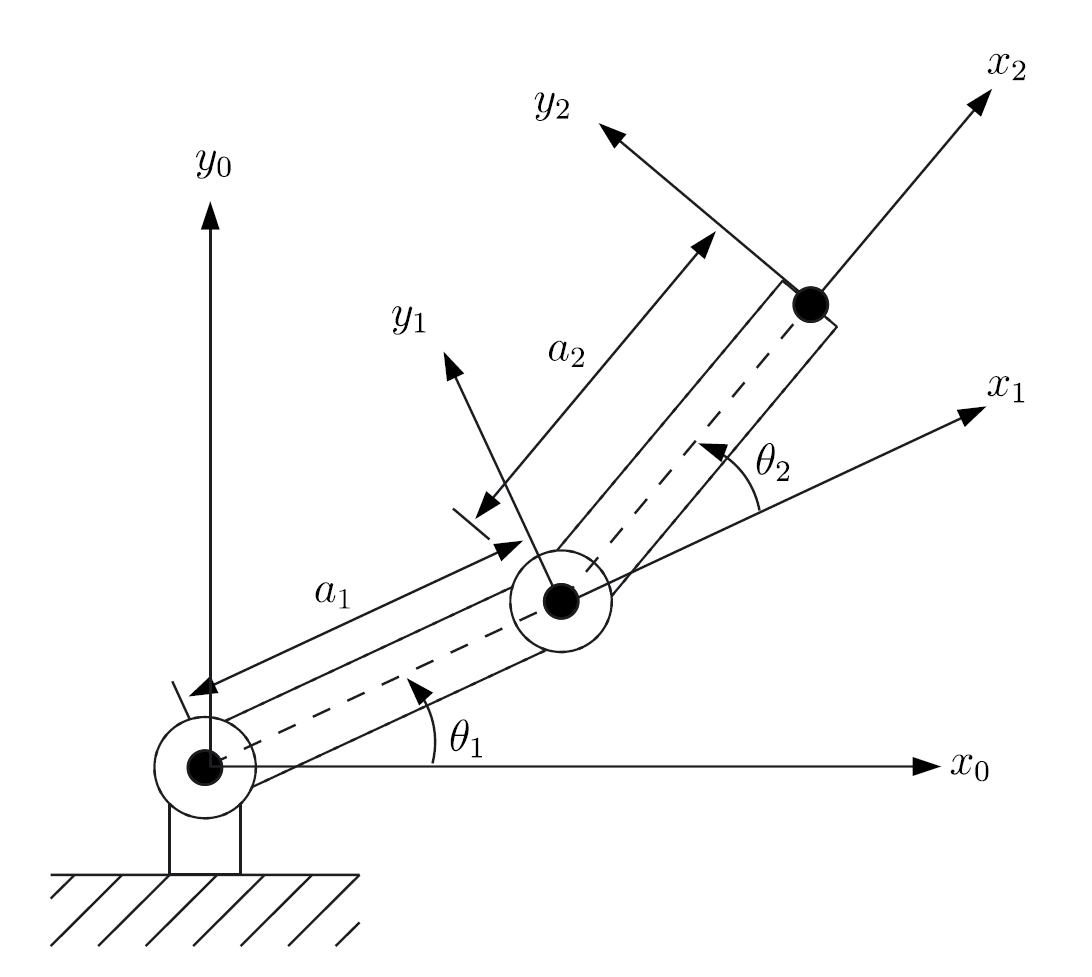

**Interaction**
- Change the value of each slider and see how the configuration of our articulated robot changes
- The homogeneous transform shown in the plot indicates the orientation and location of the end effector in the world frame
- Note: sometimes the interaction would not refresh after slider changes. You will not see any errors. Unfortunately, you will need to shut down the notebook and re-run everything until it becomes responsive.

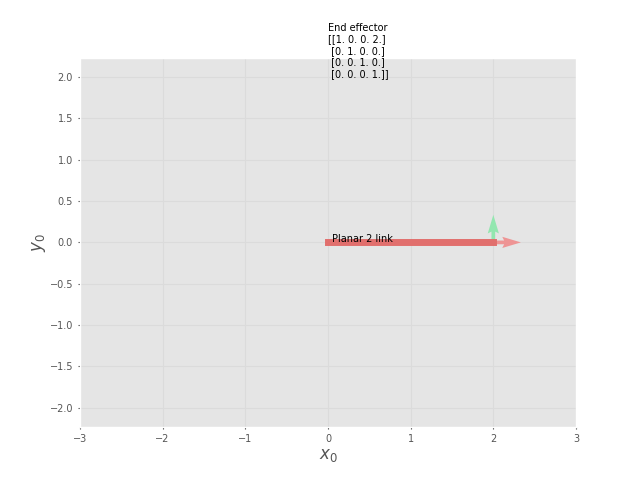

In [10]:
# Create manipulator
bot = rtb.models.DH.Planar2()

# Create visualization context
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('equal')
ax.set_xlim(-3.0, 3.0)
ax.set_ylim(-3.0, 3.0)
ax.set_xlabel(r'$x_0$', fontsize=12)
ax.set_ylabel(r'$y_0$', fontsize=12)

# Create visualizer instance
my_plot = RobotJupyterPlot(bot, ax, readonly=True)

# Plot robot
my_plot.draw2()

# Callback method associated to slider events
def rotate(theta1, theta2):
    """
    Apply new joint configuration (theta1, theta2) as defined by slider
    :param theta1 (float): Joint angle (in degrees) of first revolute joint 
    :param theta2 (float): Joint angle (in degrees) of second revolute joint
    """
    # Assign angles to robot
    bot.q = [np.deg2rad(theta1), np.deg2rad(theta2)]
    # Plot robot
    my_plot.draw2()
    
    
def reset(b):
    """
    Set sliders and robot back to default values
    """
    bot.q = [0, 0]
    my_plot.draw2()
    theta1_slider.value = 0
    theta2_slider.value = 0

# Create interaction sliders and reset button
theta1_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=1, description=r'$\theta_1$ (deg)',
                                    continuous_update=True)
theta2_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=1, description=r'$\theta_2$ (deg)',
                                    continuous_update=True)

btn_reset = widgets.Button(description='Reset', disabled=False, button_style='success')
btn_reset.on_click(reset)

# Define display layout, link slider to rotate method and show plot
ui = widgets.HBox([widgets.VBox([theta1_slider, theta2_slider]), btn_reset])
out = widgets.interactive_output(rotate, {'theta1': theta1_slider, 'theta2':theta2_slider})
display(ui)

# 2. Forward Kinematics

How can we determine the position and orientation of the end effector $H_{0n}$ given the joint configuration $[\theta_1, \theta_2]$ of our robot?

From the lecture slides, recall $T = \begin{bmatrix} R & \boldsymbol{d} \\ \boldsymbol{0} & 1 \end{bmatrix}$. In our current model, the relative homogeneous transformation of each link is defined as 

\begin{equation*}
T_i(q_i) = \begin{bmatrix} R_z(q_i) & \boldsymbol{0}^T \\ \boldsymbol{0} & 1 \end{bmatrix} *\begin{bmatrix} I(3) & [L_i, 0, 0]^T \\ \boldsymbol{0} & 1 \end{bmatrix} ,
\end{equation*}

where $q_i = \theta_i$ and $L_i = 1$ corresponds to the length of each link and $I(3)$ indicates an identity matrix of dimensions 3x3.

To determine the position and orientation of the end effector we need to combine all transformations according to $H_{0n} = T_1(q_1)T_2(q_2)\dots T_n(q_n)$

Let's now see how we can do this. We will use the objects ``SE3.Rx(angle)``,  ``SE3.Ry(angle)``, ``SE3.Rz(angle)`` to define pure rotations, and ``SE3(x,y,z)`` to define pure translations. 

**TODO**:
1. Given $[\theta_1, \theta_2]$ and $[l1, l2]$ build the homogenous transformation of each link
2. Combine all transformation to obtain $H_{0n}$. Homogeneous matrices can be combined using the ``*`` operator, i.e., ``T1 = SE3.Rz() * SE3(1, 0, 0)``

In [3]:
def compute_forward_kinematics_2dof_manipulator(robot):
    # Get current joint angles
    thetas = robot.q
    link_lengths = robot.a
    
    # Define end effector transformation
    H_n0 = SE3()
    
    #TODO 1: Compute transformation for first link ------------------
    T_01 = SE3.Rz(thetas[0]) * SE3(link_lengths[0], 0 ,0)
    #ENDTODO --------------------------------------------------------
    
    #TODO 2: Compute transformation for second link ----------------
    T_12 = SE3.Rz(thetas[1]) * SE3(link_lengths[1], 0 ,0)
    #ENDTODO --------------------------------------------------------
    
    #TODO 3: Combine all transformations ---------------------------
    H_0n = T_01 * T_12
    #ENDTODO --------------------------------------------------------
    
    return H_0n

### Check our solution

First, let's compare our method to the output provided by the robotics toolbox library (``fkine(.)`` method)

In [4]:
# Assign a configuration to the robot
bot.q = [np.deg2rad(90), np.deg2rad(45)]

# Print solution as given by the library
print("Solution from library:\n{}".format(bot.fkine(bot.q)))

# Print solution as given by our method
print("Solution from our method:\n{}".format(compute_forward_kinematics_2dof_manipulator(bot)))


Solution from library:
  -0.7071   -0.7071    0        -0.7071    
   0.7071   -0.7071    0         1.707     
   0         0         1         0         
   0         0         0         1         

Solution from our method:
  -0.7071   -0.7071    0        -0.7071    
   0.7071   -0.7071    0         1.707     
   0         0         1         0         
   0         0         0         1         



Next, let's visualize the manipulator and compare our output with the matrix shown in the figure below

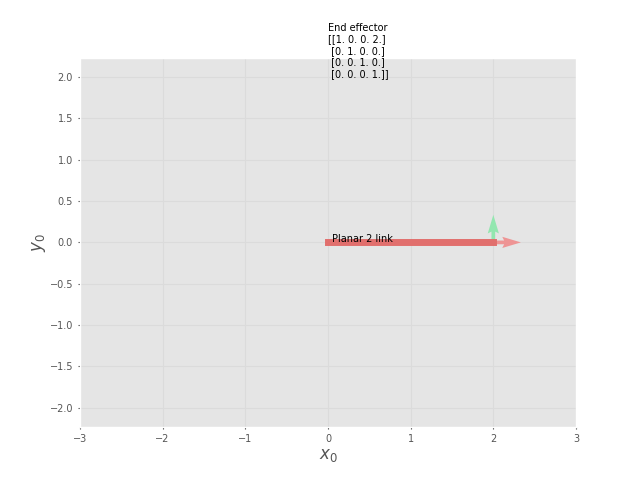

In [5]:
# Create manipulator
bot = rtb.models.DH.Planar2()

# Create visualization context
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('equal')
ax.set_xlim(-3.0, 3.0)
ax.set_ylim(-3.0, 3.0)
ax.set_xlabel(r'$x_0$', fontsize=12)
ax.set_ylabel(r'$y_0$', fontsize=12)

# Create visualizer instance
my_plot = RobotJupyterPlot(bot, ax, readonly=True)

# Plot robot
my_plot.draw2()


# Callback method associated to slider events
def rotate(theta1, theta2):
    """
    Apply new joint configuration (theta1, theta2) as defined by slider
    :param theta1 (float): Joint angle (in degrees) of first revolute joint
    :param theta2 (float): Joint angle (in degrees) of second revolute joint
    """
    # Assign angles to robot
    bot.q = [np.deg2rad(theta1), np.deg2rad(theta2)]
    # Plot robo
    my_plot.draw2()
    
    
def reset(b):
    """
    Set sliders and robot back to default values
    """
    bot.q = [0, 0]
    my_plot.draw2()
    theta1_slider.value = 0
    theta2_slider.value = 0

# Create interaction sliders and reset button
theta1_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=1, description=r'$\theta_1$ (deg)',
                                    continuous_update=True)
theta2_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=1, description=r'$\theta_2$ (deg)',
                                    continuous_update=True)

btn_reset = widgets.Button(description='Reset', disabled=False, button_style='success')
btn_reset.on_click(reset)

# Define display layout, link slider to rotate method and show plot
ui = widgets.HBox([widgets.VBox([theta1_slider, theta2_slider]), btn_reset])
out = widgets.interactive_output(rotate, {'theta1': theta1_slider, 'theta2':theta2_slider})
display(ui)

# 3. DH Pameters

Let us now look at the definition of a robotic manipulator using the Denavit-Hartenberg convention. 

Given a robot object, we can display its parameters by using ``print(bot)``. Let's see the DH parameters of our 2-dof manipulator

In [7]:
print(bot)

DHRobot: Planar 2 link, 2 joints (RR), dynamics, standard DH parameters
┌────┬────┬────┬──────┐
│θⱼ  │ dⱼ │ aⱼ │  ⍺ⱼ  │
├────┼────┼────┼──────┤
│ q1 │  0 │  1 │ 0.0° │
│ q2 │  0 │  1 │ 0.0° │
└────┴────┴────┴──────┘

┌─┬──┐
└─┴──┘

┌─────┬──────┬──────┐
│name │ q0   │ q1   │
├─────┼──────┼──────┤
│  qr │  0°  │  90° │
│  qz │  0°  │  0°  │
│  q1 │  0°  │  90° │
│  q2 │  90° │ -90° │
└─────┴──────┴──────┘



## 3.1 DH Parameters of a 3-dof manipulator

Given the image below, define the DH parameters for a 3-dof manipulator

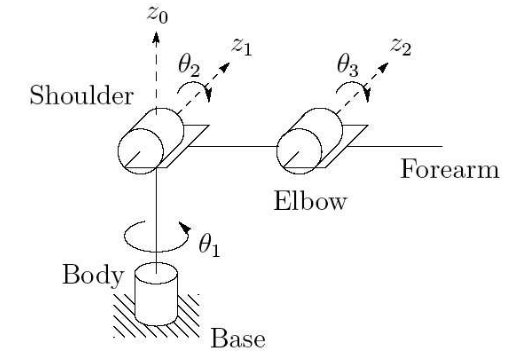


This manipulator consists of 3 revolute joints. To define a revolute joint, we use the class ``RevoluteDH`` with attributes:
- ``d``: link offset
- ``a``: link length
- ``alpha``: link twist

Similarly, to define a manipulator, we instantiate an object of type ``DHRobot`` and specify as parameter a list with all ``RevoluteDH`` joints and a name.

**TODO**: Specify the DH parameters for the 3dof manipulator shown above. ``RevoluteDH`` expects angles to be specified in radians. You can use ``np.deg2rad()`` to convert degrees to radians

In [8]:
#TODO: Define d, a, and alpha for all links ---------------------
link1 = RevoluteDH(d=0.5, a=0, alpha=np.deg2rad(-90))
link2 = RevoluteDH(d=0, a=0.5, alpha=0)
link3 = RevoluteDH(d=0, a=0.5, alpha=0)
#ENDTODO --------------------------------------------------------

my_bot = DHRobot([link1, link2, link3], name='3dof-manipulator')
print(my_bot)

DHRobot: 3dof-manipulator, 3 joints (RRR), dynamics, standard DH parameters
┌────┬─────┬─────┬────────┐
│θⱼ  │ dⱼ  │ aⱼ  │   ⍺ⱼ   │
├────┼─────┼─────┼────────┤
│ q1 │ 0.5 │   0 │ -90.0° │
│ q2 │   0 │ 0.5 │   0.0° │
│ q3 │   0 │ 0.5 │   0.0° │
└────┴─────┴─────┴────────┘

┌─┬──┐
└─┴──┘



Let us visualize our 3dof manipulator

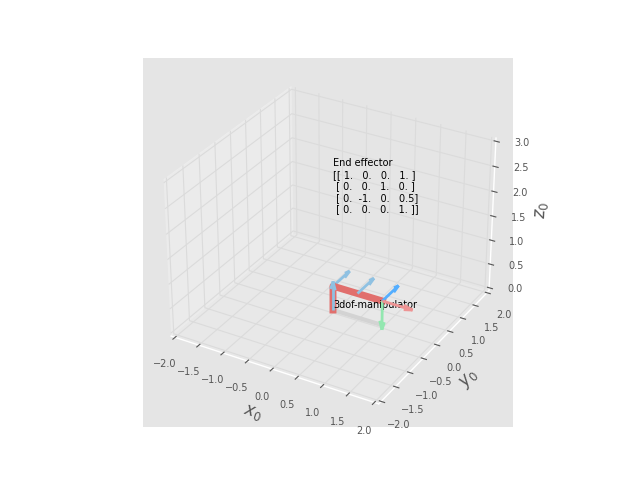

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-2.0, 2.0)
ax.set_ylim3d(-2.0, 2.0)
ax.set_zlim3d(0.0, 3.0)
ax.set_xlabel(r'$x_0$', fontsize=12)
ax.set_ylabel(r'$y_0$', fontsize=12)
ax.set_zlabel(r'$z_0$', fontsize=12)

my_plot = RobotJupyterPlot(my_bot, ax, readonly=True)
my_plot.draw()


def rotate(theta1, theta2, theta3):
    """
    Apply new joint configuration (theta1, theta2, theta3) as defined by slider
    :param theta1 (float): Joint angle (in degrees) of first revolute joint
    :param theta2 (float): Joint angle (in degrees) of second revolute joint
    :param theta3 (float): Joint angle (in degrees) of third revolute joint
    """
    my_bot.q = [np.deg2rad(theta1), np.deg2rad(theta2), np.deg2rad(theta3)]
    my_plot.draw()
    
    
def reset(b):
    """
    Set sliders and robot back to default values
    """
    my_bot.q = [0, 0, 0]
    my_plot.draw()
    theta1_slider.value = 0
    theta2_slider.value = 0
    theta3_slider.value = 0
    
    
theta1_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=.1, description=r'$\theta_1$ (deg)',
                                    continuous_update=True)
theta2_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=.1, description=r'$\theta_2$ (deg)',
                                    continuous_update=True)
theta3_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=.1, description=r'$\theta_3$ (deg)',
                                    continuous_update=True)


btn_reset = widgets.Button(description='Reset', disabled=False, button_style='success')
btn_reset.on_click(reset)

# Define display layout, link slider to rotate method and show plot
ui = widgets.HBox([widgets.VBox([theta1_slider, theta2_slider, theta3_slider]), btn_reset])
out = widgets.interactive_output(rotate, {'theta1': theta1_slider, 
                                          'theta2': theta2_slider,
                                          'theta3': theta3_slider})
display(ui)

In [ ]:
my_bot.q=[0, 45, -45]

my_bot.q=[np.pi/6, np.deg2rad(4), -np.pi/10]
my_bot.fkine(my_bot.q)

# 4. Jacobian Matrix 3-Dof Manipulator

The Jacobian matrix of a manipulator is defined as

\begin{equation}
J = 
\begin{bmatrix}
\boldsymbol{z}^0_0 \times \boldsymbol{d}^0_{0e} & \cdots & {z}^0_{n-1} \times \boldsymbol{d}^0_{n-1e}\\
\boldsymbol{z}^0_0 & \dots & \boldsymbol{z}^0_{n-1}
\end{bmatrix}
\end{equation}

where $\boldsymbol{z}^0_{i-1}$ corresponds to the axis of the $i$-th joint and $\boldsymbol{d}^0_{i-1e}$ defines the vector pointing from the $i$-th joint to the end-effector; both given in world coordinates.

Thus, in order to compute the Jacobian for our 3dof manipulator:
1. Compute forward kinematics for all links (we will use ``fkine_all(.)``) to do so
2. Find $\boldsymbol{z}^0_{i-1}$ and $\boldsymbol{d}^0_{i-1e}$ for all joints (recall that all joints in our manipulator are revolute joints along the z-axis)
    - To access the axis of a joint, use T.a
    - To access the position of a joint, use T.t
3. Form the Jacobian according to the equation provided above

**TODO**: Complete the missing steps
1. Compute the vector pointing from the $i$-th joint to the end-effector $\boldsymbol{d}^0_{i-1e}$
2. Compute the cross product between the axis of the $i$-th joint $\boldsymbol{z}^0_{i-1}$ and $\boldsymbol{d}^0_{i-1e}$. Use the method ``np.cross(.)`` to do so.

In [11]:
def compute_jacobian(robot):
    """
    Compute jacobian matrix for a given robot configuration
    :param robot (DHRobot): Robot object for which Jacobian will be computed
    :return 6xn matrix: Jacobian matrix of dimensions 6 x num joints in robot
    """
    
    #Create an empty Jacobian matrix
    J = np.zeros((6, robot.n))
        
    # Compute forward dynamics
    T_all = robot.fkine_all()  
    
    #Get end-effector position in world coordinates
    end_effector_position = robot.fkine(robot.q).t
    
    for i in range(robot.n):
        # Get joint axis (z-axis in our case)
        joint_axis = T_all[i].a
        # Get joint's position
        joint_position = T_all[i].t
        
        #TODO 1: Compute vector pointing from joint to end effector -----
        joint_to_end_effector = end_effector_position - joint_position
        #ENDTODO --------------------------------------------------------
        
        #TODO 2: Compute cross product between joint_axis and d_ie ------
        cross_v = np.cross(joint_axis, joint_to_end_effector)
        #ENDTODO --------------------------------------------------------
        
        # Assign entries to Jacobian matrix        
        J[:3,i] = cross_v
        J[3:, i] = joint_axis
        
    return J

Let's test our code

In [12]:
# Reset robot to default configuration
my_bot.q = [0, 0, 0]

# Let's compute the end effector linear and angular velocities when q = [0, 0 , 0] and dq = [0, 1, 0]
J = compute_jacobian(my_bot) 
dx = J @ np.array([0,1,0])

# Print Jacobian and velocity
print("The Jacobian matrix is:\n{}\n".format(np.round(J, 6)))
print("The end effector linear and angular velocites:\n{}".format(np.round(dx,4)))

The Jacobian matrix is:
[[ 0.   0.   0. ]
 [ 1.   0.   0. ]
 [ 0.  -1.  -0.5]
 [ 0.   0.   0. ]
 [ 0.   1.   1. ]
 [ 1.   0.   0. ]]

The end effector linear and angular velocites:
[ 0.  0. -1.  0.  1.  0.]
